# The project architecture was created with cookiecutter

In [1]:
#cookiecutter https://github.com/drivendata/cookiecutter-data-science.git

# Download the dataset

In [2]:
#!cd ../data/raw

In [3]:
#!pwd
#!kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs -p ../data/raw

In [4]:
#%cd ../../notebooks
#%cd ../data/raw
#!ls
#!unzip price-volume-data-for-all-us-stocks-etfs.zip 
#!ls
#%cd ../../notebooks


# Libraries to install 

In [5]:
#!npm install -g electron@1.8.4 orca
# !pip3 install --upgrade pip
#!pip3 install plotly
#!pip install --upgrade pandas
#!pip3 install psutil requests

In [6]:
%matplotlib inline

# Load dataset 

In [7]:
import pandas as pd
import os
import numpy as np

def load_dataset(subfolder='', file='aapl.us.txt',data_type='raw',index_column=0):
    data_path = os.path.join(os.path.pardir, 'data', data_type, subfolder, file)
    print('Opening file ', data_path)
    df = pd.read_csv(data_path , index_col=index_column)
    print ('%d missing values found' % df.isnull().sum().sum())
    return df


# Process Data - Generate feature vector

In [154]:
import pandas as pd


def prepare_feture_vector(df):
    # Feature vector

    df_tomorrow = generate_tomorrow_dataset(df)
    df_yesterday = generate_yesterday_dataset(df)
    # concatenate yesterday - today and tomorrow
    df = pd.concat([df_yesterday, df, df_tomorrow], axis=1, sort=False)

    # eliminate nan values from before yesterday and after tomorrow
    df = df[1:-2]
    return (df
            .assign(Date=lambda x: pd.to_datetime(x.Date))
            .assign(Average_High_Low=lambda x: (x.High + x.Low) / 2)
            .assign(Average_Day=lambda x: (x.Open + x.Close) / 2)
            .assign(Diff_Close_Open=lambda x: (x.Close - x.Open) / x.Open)
            .assign(Diff_Tomorrow_Open=lambda x: ((x.Tomorrow_Open - x.Open) / x.Open)*100)
            .assign(Label=lambda x: np.where(((x.Tomorrow_Open - x.Open) > 0), 1, 0))
            .assign(Diff_Today_Open=lambda x: ((x.Open - x.Yesterday_Open) / x.Yesterday_Open)*100)
            .assign(Diff_Today_Close=lambda x: ((x.Close - x.Yesterday_Close) / x.Yesterday_Close)*100)
            .assign(Diff_Today_High=lambda x: ((x.High - x.Yesterday_High) / x.Yesterday_High)*100)
            .assign(Diff_Today_Low=lambda x: ((x.Low - x.Yesterday_Low) / x.Yesterday_Low)*100)
            .assign(Month = lambda x: x.Date.dt.month)
            .assign(Year = lambda x: x.Date.dt.year)
            .assign(Day = lambda x: x.Date.dt.day)
            .assign(Yesterday_Month = lambda x: pd.to_datetime(x.Yesterday_Date).dt.month)
            .assign(Yesterday_Year = lambda x: pd.to_datetime(x.Yesterday_Date).dt.year)
            .assign(Yesterday_Day = lambda x: pd.to_datetime(x.Yesterday_Date).dt.day)
            )


def generate_tomorrow_dataset(today_dataset):
    df_tomorrow = today_dataset[['Date', 'Open']].copy()
    df_tomorrow = df_tomorrow[1:]
    df_tomorrow.columns = ['Tomorrow_Date', 'Tomorrow_Open']
    df_tomorrow['aux_index'] = df_tomorrow.index - 1
    df_tomorrow.set_index('aux_index', inplace=True, drop=True)

    return df_tomorrow


def generate_yesterday_dataset(today_dataset):
    df_yesterday = today_dataset[['Date', 'Open', 'Close', 'Volume', 'Low', 'High']].copy()
    df_yesterday.columns = ['Yesterday_Date', 'Yesterday_Open', 'Yesterday_Close', 'Yesterday_Volume', 
                            'Yesterday_Low',
                            'Yesterday_High']
    df_yesterday['aux_index'] = df_yesterday.index + 1
    df_yesterday.set_index('aux_index', inplace=True, drop=True)

    return df_yesterday



# Write processed data - Dataset with feature vector

In [155]:
import pandas as pd
import numpy as np

def process_dataset(product='Stocks', underlyer='aapl.us.txt'):
    dataset = load_dataset(product, underlyer,'raw',index_column=False)
    dataset = prepare_feture_vector(dataset)
    write_data(dataset,'feature_vector')
    return dataset


def write_data(dataset,filename_extension):
    processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
    dataset_path = os.path.join(processed_data_path, 'dataset_' + filename_extension + '.csv')
    dataset.to_csv(dataset_path)
    
def generate_train_dataset(dataset, split_date='2016-01-01'):
    dataset_aux = dataset[dataset.Date < split_date]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


def generate_train_dataset_lowerbound(dataset, split_date='2016-01-01', lower_bound = '2000-01-01'):
    dataset_aux = dataset[(dataset.Date < split_date) & (dataset.Date > lower_bound)]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


def generate_test_dataset(dataset, split_date='2016-01-01'):
    dataset_aux = dataset[dataset.Date > split_date]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


# Explore data - Visualizations 

In [165]:
dataset= process_dataset()
dataset[['Yesterday_Date','Yesterday_Open','Open','Tomorrow_Open','Label']].tail()

Opening file  ../data/raw/Stocks/aapl.us.txt
0 missing values found


,Yesterday_Date,Yesterday_Open,Open,Tomorrow_Open,Label
8358,2017-11-02,167.04,173.38,171.75,0
8359,2017-11-03,173.38,171.75,173.29,1
8360,2017-11-06,171.75,173.29,174.03,1
8361,2017-11-07,173.29,174.03,174.48,1
8362,2017-11-08,174.03,174.48,175.11,1


In [157]:
dataset.describe(include="all")


,Yesterday_Date,Yesterday_Open,Yesterday_Close,Yesterday_Volume,Yesterday_Low,Yesterday_High,Date,Open,High,Low,...,Diff_Today_Open,Diff_Today_Close,Diff_Today_High,Diff_Today_Low,Month,Year,Day,Yesterday_Month,Yesterday_Year,Yesterday_Day
count,8362,8362.000000,8362.000000,8.362000e+03,8362.000000,8362.000000,8362,8362.000000,8362.000000,8362.000000,...,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000
unique,8362,NaN,NaN,NaN,NaN,NaN,8362,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1985-10-25,NaN,NaN,NaN,NaN,NaN,1989-12-27 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,1984-09-10 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-09 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,22.247873,22.244501,1.066606e+08,22.018047,22.459291,NaN,22.268688,22.480222,22.038628,...,0.113966,0.113125,0.104137,0.108971,6.556446,2000.755083,15.741569,6.556207,2000.751136,15.741330
std,NaN,37.694171,37.695077,9.935617e+07,37.378675,37.988710,NaN,37.730159,38.024774,37.414145,...,2.890777,2.837490,2.529073,2.689975,3.430131,9.586926,8.744951,3.429891,9.587030,8.745163
min,NaN,0.233050,0.230510,0.000000e+00,0.230510,0.235640,NaN,0.233050,0.235640,0.230510,...,-42.816429,-51.846338,-46.112997,-47.257562,1.000000,1984.000000,1.000000,1.000000,1984.000000,1.000000
25%,NaN,1.137100,1.137100,4.384834e+07,1.112800,1.164200,NaN,1.137100,1.164200,1.112800,...,-1.345140,-1.317076,-1.088744,-1.124607,4.000000,1992.000000,8.000000,4.000000,1992.000000,8.000000


In [198]:
import numpy as np
import pandas as pd
from plotly.basedatatypes import BaseFigure
from plotly.graph_objs import Candlestick
from plotly.graph_objs._figure import Figure
import plotly.graph_objects as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import matplotlib
import matplotlib.pyplot as plt
# gca stands for 'get current axis'
from matplotlib.pyplot import figure
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, PercentFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

def generate_candle_plot_with_split(dataset, date_split_str='2017-01-01', lower_bound_date='',
                         colors = ['green', 'red','darkgreen', 'darkred'], 
                         title = 'Apple stocks price evolution'):
    date_split = pd.to_datetime(date_split_str)
    if lower_bound_date!='' :
        left_df = dataset[(dataset.Date < date_split) & (dataset.Date > pd.to_datetime(lower_bound_date))]
    else:
        left_df = dataset[dataset.Date < date_split]
        
    right_df = dataset[dataset.Date > date_split]

    data = [
            Candlestick(x=left_df.Date, open=left_df.Open, high=left_df.High, 
                        low=left_df.Low, close=left_df.Close, name='Left',
                        increasing_line_color= colors[0], decreasing_line_color= colors[1]),
            Candlestick(x=right_df.Date, open=right_df.Open, high=right_df.High, 
                        low=right_df.Low, close=right_df.Close, name='Right',
                       increasing_line_color= colors[2], decreasing_line_color= colors[3])
        ]
    layout = {
             'title': title,
             'yaxis_title':'AAPL Stock Price (U$S)',
             'xaxis_title':'Time (Days)',
             'shapes': [
                 {'x0': date_split, 'x1': date_split, 
                  'y0': 0, 'y1': 1, 
                  'xref': 'x', 'yref': 'paper', 
                  'line': {'color': 'rgb(0,0,0)', 'width': 1}}
             ],
            'annotations': [
                {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 
                 'xanchor': 'left', 'text': ' test data'},
                {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 
                 'xanchor': 'right', 'text': 'train data '}
            ]
        }
    figure = go.Figure(data=data, layout=layout)
    figure.show()
    figure.update_layout(xaxis_rangeslider_visible=False)
    visualization_path = os.path.join(os.path.pardir, 'reports', 'figures', 'exploration', 'candle_plot_split')
    figure.write_image('{0}.png'.format(visualization_path))


def generate_candle_plot(dataset, colors = ['green','red'], title = 'Apple stocks price evolution',lower_bound_date=''):
   
    plot_dataset=dataset
    if lower_bound_date!='' :
        plot_dataset = dataset[dataset.Date > pd.to_datetime(lower_bound_date)]
    
    data = Candlestick(x=plot_dataset.Date, open=plot_dataset.Open, high=plot_dataset.High, 
                        low=plot_dataset.Low, close=plot_dataset.Close, name='Serie',
                        increasing_line_color= colors[0], decreasing_line_color= colors[1])
    layout = {'title': title,
             'yaxis_title':'AAPL Stock Price (U$S)',
             'xaxis_title':'Time (Days)',
              'annotations': [
                    {'x': plot_dataset.Date.iloc[1], 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 
                     'xanchor': 'left', 'text': 'Data Serie'}
                ]
            }
    figure = go.Figure(data=data, layout=layout)
    figure.show()
    figure.update_layout(xaxis_rangeslider_visible=False)
    visualization_path = os.path.join(os.path.pardir, 'reports', 'figures', 'exploration', 'simple_candle_plot_split')
    figure.write_image('{0}.png'.format(visualization_path))



def plot_differences(df, y1,y2,title, image_name='difference.png'):
    majorLocator = MultipleLocator(y1['ticker']['locator']['major'])
    minorLocator = MultipleLocator(y1['ticker']['locator']['minor'])

    figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    if y1['ticker']['formatter']!='' and y1['ticker']['formatter']=='%':
        formatter = PercentFormatter(xmax=5)
    else:
        formatter = FormatStrFormatter('$%1.2f')
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.set_ylabel(y1['ticker']['text'])
    ax.set_ylim(y1['ticker']['limit']['min'], y1['ticker']['limit']['max'])
    # Define the date format
    date_form = DateFormatter("%d/%m/%y")
    ax.xaxis.set_major_formatter(date_form)
    # Ensure ticks fall once every four week (interval=4) 
#     ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

    df.plot(kind='line',x=x['series'][0],y=y1['series'][0], color=y1['colors'][0],ax=ax, title=title)
    df.plot(kind='line',x=x['series'][0],y=y1['series'][1], color=y1['colors'][1], ax=ax)
    ax.legend([y1["legends"][0], y1["legends"][1]], loc='upper left')

    if y2!='' :
        ax2 = ax.twinx()
        ax2.yaxis.set_major_formatter(formatter)          
        ax2.xaxis.set_major_formatter(date_form)  
        ax2.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
#         ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        if y2['ticker']['formatter']!='' and y2['ticker']['formatter']=='%':
            formatter = PercentFormatter()
        else:
            formatter = FormatStrFormatter('$%1.2f')
        ax2.yaxis.set_major_formatter(formatter)
        ax2.set_ylim(y2['ticker']['limit']['min'], y2['ticker']['limit']['max'])
        ax2.tick_params(axis='y', labelcolor = y2['ticker']['color'])
        ax2.set_ylabel(y2["ticker"]['text'], color = y2['ticker']['color'])  # we already handled the x-label with ax1
        df.plot(kind='line',x=x['series'][0],y=y2['series'][0], color=y2['colors'][0], ax=ax2)
        ax2.hlines(2, df.Date.min(), df.Date.max(), colors='brown', linestyles='dotted')
        ax2.hlines(-2, df.Date.min(), df.Date.max(), colors='brown', linestyles='dotted')
        ax2.legend([y2["legends"][0]])
        
    visualization_path = os.path.join(os.path.pardir, 'reports', 'figures', 'exploration', image_name)
    plt.savefig('{0}.png'.format(visualization_path))
    plt.show()



In [186]:
generate_candle_plot(dataset, lower_bound_date='2005-01-01')

In [187]:
generate_candle_plot_with_split(dataset, '2016-11-09', '2005-01-01')

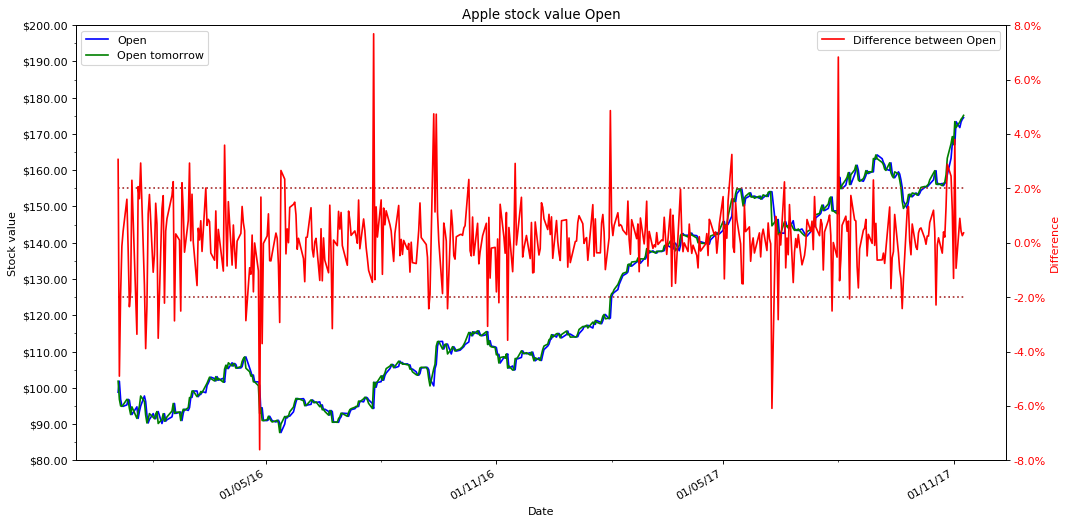

In [199]:

df_comparison = dataset[dataset.Date >= '2016-01-01']

y1 = {'series' : ['Open','Tomorrow_Open'],
       'ticker' : {'text':'Stock value',
                   'locator':{
                       'major':10,
                       'minor':5
                   },
                   'limit':{
                      'min':80,
                      'max':200,
                      },
                   'formatter':''
                  },
       'colors': ['blue', 'green'],
       'legends' : ["Open", "Open tomorrow"]
     }

y2 = {'series' : ['Diff_Tomorrow_Open'],
       'ticker' : {'text':'Difference',
                  'color': 'red',
                  'limit':{
                      'min':-8,
                      'max':8,
                  },
                   'formatter':'%'
                  },
        'colors': ['red'],
        'legends' : ["Difference between Open"]
     }
x = {'series' : ['Date']}

plot_differences(df_comparison,y1, y2,'Apple stock value Open','differenceOpenTodayTomorrow_2016')

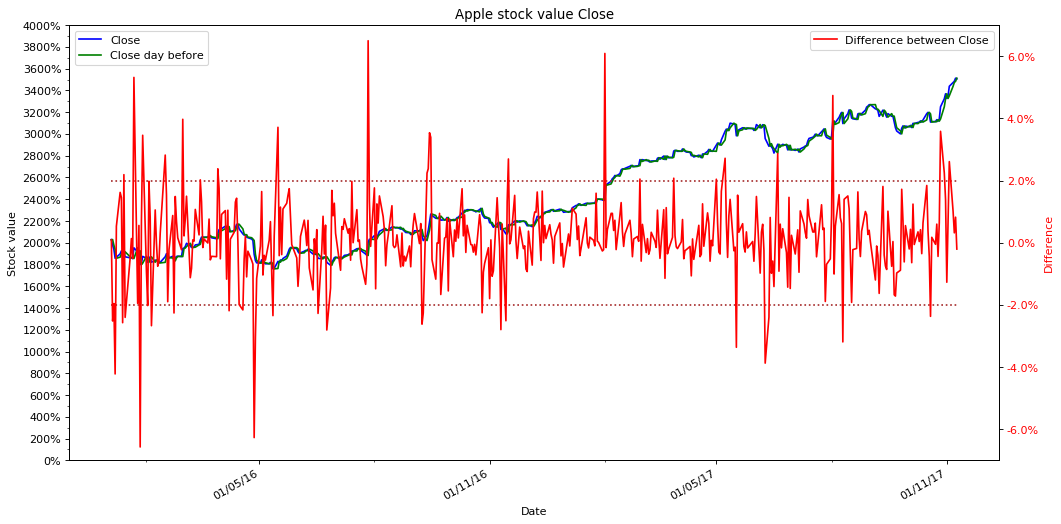

In [200]:
y1 = {'series' : ['Close','Yesterday_Close'],
       'ticker' : {'text':'Stock value',
                   'locator':{
                       'major':10,
                       'minor':5
                   }, 
                   'limit':{
                      'min':0,
                      'max':200,
                      },
                   'formatter':'%'
                  },
       'colors': ['blue', 'green'],
       'legends' : ["Close", "Close day before"]
     }

y2 = {'series' : ['Diff_Today_Close'],
       'ticker' : {'text':'Difference',
                  'color': 'red',
                  'limit':{
                      'min':-7,
                      'max':7,
                      },
                   'formatter':'%'
                  },
        'colors': ['red'],
        'legends' : ["Difference between Close"]
     }
x = {'series' : ['Date']}
plot_differences(df_comparison,y1, y2,'Apple stock value Close','differenceCloseTodayTomorrow_2016')

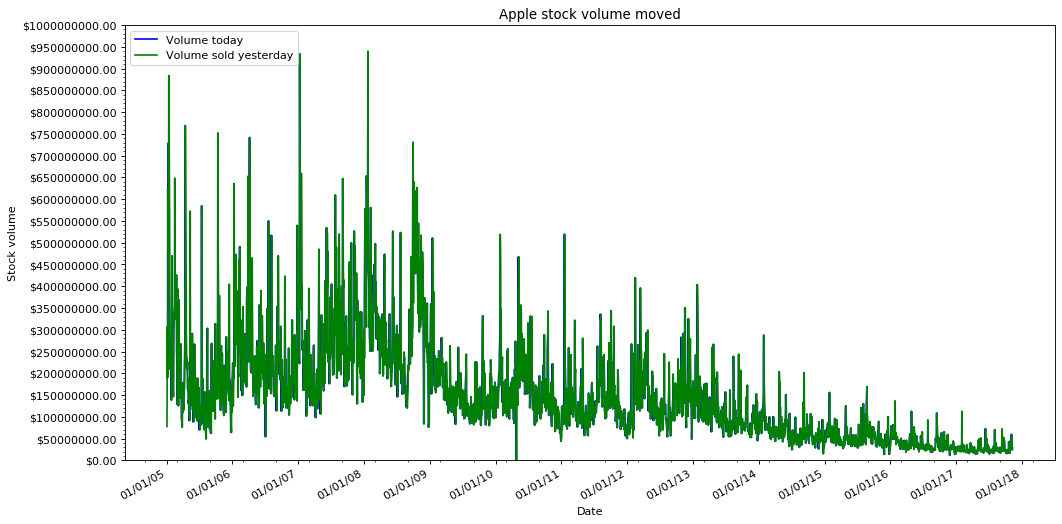

In [116]:
y1 = {'series' : ['Volume','Yesterday_Volume'],
       'ticker' : {'text':'Stock volume',
                   'locator':{
                       'major':5.0E+7,
                       'minor':1.0E+7
                   },
                  'limit':{
                      'min':-100,
                      'max':10E+8,
                      },
                   'formatter':'$'
                  },
       'colors': ['blue', 'green'],
       'legends' : ["Volume today", "Volume sold yesterday"]
     }

x = {'series' : ['Date']}
plot_differences(df_comparison,y1,'','Apple stock volume moved','differenceVolumeTodayTomorrow_2005')

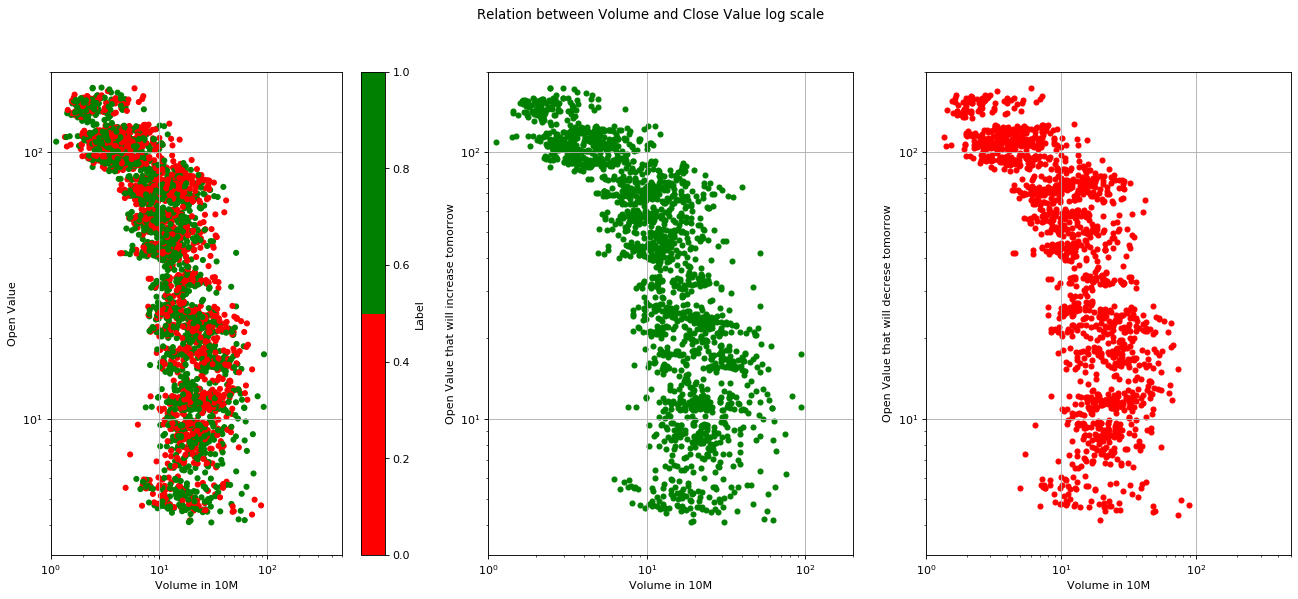

In [111]:
from matplotlib.pyplot import figure
import matplotlib

colors=['red','green']
cmap = matplotlib.colors.ListedColormap(colors)
dataset_volume = df_comparison.assign(Volume_norm=lambda x: x.Volume/10000000)

fig = figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# fig.tight_layout(pad=5.0)
plt.subplot(131)
ax = plt.gca()
dataset_volume.plot(kind='scatter',y='Open', x='Volume_norm',c='Label', cmap= cmap, ax=ax,title = '')
ax.set_ylim(dataset_volume.Open.min() -1 , 200)
ax.set_xlim(1, 500)
ax.set_xlabel('Volume in 10M')
ax.set_ylabel('Open Value')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

plt.subplot(132)
ax = plt.gca()
green=dataset_volume[dataset_volume.Label==1]
green.plot(kind='scatter',y='Open', x='Volume_norm',c='green', ax=ax,title = '')
ax.set_xlabel('Volume in 10M')
ax.set_ylabel('Open Value that will increase tomorrow')
plt.xscale('log')
plt.yscale('log')
ax.set_ylim(dataset_volume.Open.min() -1 , 200)
ax.set_xlim(1, 200)
plt.grid(True)

plt.subplot(133)
ax = plt.gca()
red=dataset_volume[dataset_volume.Label==0]
red.plot(kind='scatter',y='Open', x='Volume_norm', ax=ax,color='red', title = '')
ax.set_xlabel('Volume in 10M')
ax.set_ylabel('Open Value that will decrese tomorrow')
plt.xscale('log')
plt.yscale('log')
ax.set_ylim(dataset_volume.Open.min() -1 , 200)
ax.set_xlim(1, 500)
plt.grid(True)


fig.suptitle('Relation between Volume and Close Value log scale')
visualization_path = os.path.join(os.path.pardir, 'reports', 'figures', 'classifier', "relationOpenVolumeLog.png")
plt.savefig('{0}.png'.format(visualization_path))
plt.show()    


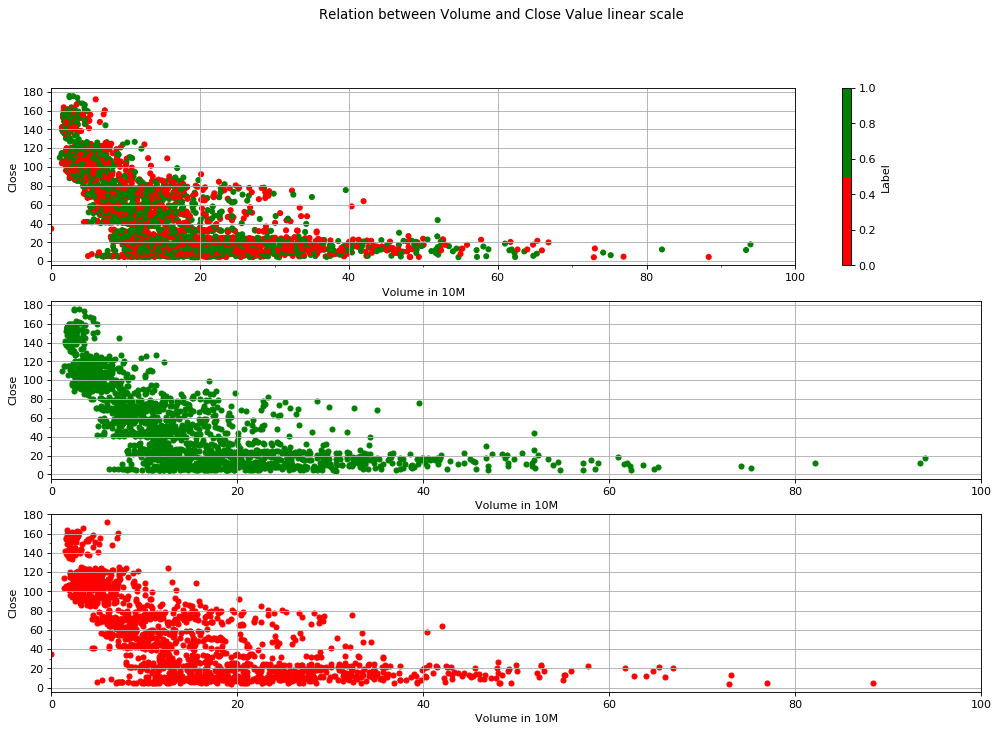

In [112]:
colors=['red','green']
cmap = matplotlib.colors.ListedColormap(colors)

fig = figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(311)
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
dataset_volume.plot(kind='scatter',y='Close', x='Volume_norm',c='Label', cmap= cmap, ax=ax,title = '')
ax.set_xlabel('Volume in 10M')
ax.set_xlim(0, 100)
plt.grid(True)

plt.subplot(312)
ax = plt.gca()
green=dataset_volume[dataset_volume.Label==1]
green.plot(kind='scatter',y='Close', x='Volume_norm',c='green', ax=ax,title = '')
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.set_xlabel('Volume in 10M')
ax.set_xlim(0, 100)
plt.grid(True)

plt.subplot(313)
ax = plt.gca()
red=dataset_volume[dataset_volume.Label==0]
red.plot(kind='scatter',y='Close', x='Volume_norm', ax=ax,color='red', title = '')
ax.set_xlabel('Volume in 10M')
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.set_xlim(0, 100)
plt.grid(True)


fig.suptitle('Relation between Volume and Close Value linear scale')
visualization_path = os.path.join(os.path.pardir, 'reports', 'figures', 'classifier', "relationCloseVolumeLog.png")
plt.savefig('{0}.png'.format(visualization_path))
plt.show() 

# Volume - Difference analisis

## Process Volume - Difference data

In [166]:
df = load_dataset('', 'dataset_feature_vector.csv','processed',0)
volume_per_year_df= df.groupby('Year').agg( 
    Max_Volume = ('Volume',max),
    Min_Volume = ('Volume',min),
    Mean_Volume = ('Volume','mean'),
    Min_Diff_Open = ('Diff_Today_Open',min),
    Max_Diff_Open = ('Diff_Today_Open',max),
    Mean_Diff_Open = ('Diff_Today_Open','mean'),
    Count = ('Volume','count'),
    Count_Earns = ('Label',sum),
)



volume_per_year_df= (volume_per_year_df
                        .assign(Count_Losses = lambda x: x.Count - x.Count_Earns)
                        .assign(Year = lambda x: x.index)
                        .assign(index = lambda x: x.index - x.Year.min()))
volume_per_year_df.set_index('index', inplace=True, drop=True)

write_data(volume_per_year_df,'volume_per_year')


volume_per_year_per_month_df= df.groupby(['Year','Month']).agg( 
    Max_Volume_Month = ('Volume',max),
    Min_Volume_Month = ('Volume',min),
    Mean_Volume_Month = ('Volume','mean'),
    Min_Diff_Open_Month = ('Diff_Today_Open',min),
    Max_Diff_Open_Month = ('Diff_Today_Open',max),
    Mean_Diff_Open_Month = ('Diff_Today_Open','mean'),
    Count_Month = ('Volume','count'),
    Count_Earns_Month = ('Label',sum),
)

volume_per_year_per_month_df= (volume_per_year_per_month_df
                        .assign(Count_Losses_Month = lambda x: x.Count_Month - x.Count_Earns_Month)
                       .assign(Year = lambda x: x.index.get_level_values(0) )
                       .assign(Month = lambda x: x.index.get_level_values(1) )
                       .assign(index = lambda x: x.index.get_level_values(0) *100 + x.index.get_level_values(1)*8))
volume_per_year_per_month_df.set_index('index', inplace=True, drop=False)


write_data(volume_per_year_per_month_df,'volume_per_year_per_month')
volume_per_year_per_month_df.head(20)

Opening file  ../data/processed/dataset_feature_vector.csv
0 missing values found


,Max_Volume_Month,Min_Volume_Month,Mean_Volume_Month,Min_Diff_Open_Month,Max_Diff_Open_Month,Mean_Diff_Open_Month,Count_Month,Count_Earns_Month,Count_Losses_Month,Year,Month,index
index,,,,,,,,,,,,
198472,68847968.0,18022532.0,3.835188e+07,-3.644079,3.781894,-0.189161,15,5,10,1984,9,198472
198480,101750813.0,13099922.0,4.320330e+07,-3.665759,3.682520,-0.107541,23,8,15,1984,10,198480
198488,114488422.0,7721268.0,4.475486e+07,-4.057308,5.478727,0.103693,21,6,15,1984,11,198488
198496,137914578.0,18640984.0,4.817734e+07,-3.917494,5.934147,0.719054,20,9,11,1984,12,198496
198508,152694928.0,38281489.0,8.070389e+07,-7.185604,4.478133,0.154289,22,6,16,1985,1,198508
198516,146978950.0,27480461.0,6.947694e+07,-6.014632,2.680528,-0.893232,19,6,13,1985,2,198516
198524,204694810.0,22414173.0,6.129567e+07,-10.102757,5.169731,-0.592408,21,8,13,1985,3,198524
198532,73595683.0,16685685.0,3.808784e+07,-6.150704,7.366636,-0.106106,21,5,16,1985,4,198532
198540,164395532.0,15654933.0,5.880794e+07,-9.366173,6.789931,-0.805112,22,6,16,1985,5,198540


## Visualize Volume Data

In [178]:
from matplotlib.ticker import FuncFormatter
def plot_volume_year_summary(df,x,y,title):
    fig = figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    if 'locator' in x['ticker'].keys():
        ax.xaxis.set_major_locator(MultipleLocator(x['ticker']['locator']['major']))
        ax.xaxis.set_minor_locator(MultipleLocator(x['ticker']['locator']['minor']))

        
    df.plot(kind=y['kind'][0],x = x['series'][0], y=y['series'][0],color=y['color'][0], ax=ax,title=title, label=y['names'][0])
    df.plot(kind=y['kind'][1],x = x['series'][0], y=y['series'][1],color=y['color'][1], ax=ax, label=y['names'][1])
    df.plot(kind=y['kind'][2],x = x['series'][0], y=y['series'][2],color=y['color'][2], ax=ax, label=y['names'][2])
    
    ax.set_xlabel(x['ticker']['text'])
    ax.set_ylabel(y['ticker']['text'])
    ax.set_xlim(x['limits'][0],x['limits'][1])
    
    if 'formatter' in x['ticker'].keys():
        ax.xaxis.set_major_formatter(FuncFormatter(lambda value, pos: '%02d - %s' %(((value % 100)/8), str(value)[0:4])))
        ax.xaxis.set_minor_formatter(FuncFormatter(lambda value, pos: (('%02d' % ((value % 100)/8)))))
        plt.xticks(rotation=70)
    
    plt.show() 

def plot_max_min_year_behavior(df,y,title):
    fig = figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(211)
    ax = plt.gca()
    df.plot(kind='line',x='Year', y=y['series'][0],color='red', ax=ax)
    df.plot(kind='line',x='Year', y=y['series'][1],color='red', ax=ax)
    df.plot(kind='scatter',x='Year', y=y['series'][2],color='blue', ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel(y['ticker']['text'])
    ax.set_xlim(1984, 2017)


    plt.subplot(212)
    ax = plt.gca()
    df.plot(kind='line',x='Date', y=y['series'][0],color='red', ax=ax)
    df.plot(kind='line',x='Date', y=y['series'][1],color='red', ax=ax)
    df.plot(kind='line',x='Date', y=y['series'][2], ax=ax, marker='.',
                markerfacecolor='None',
                markeredgecolor='blue',
                linestyle = 'None')

    ax.set_xlabel('Date')
    ax.set_ylabel(y['ticker']['text'])

    fig.suptitle(title)
    plt.show() 

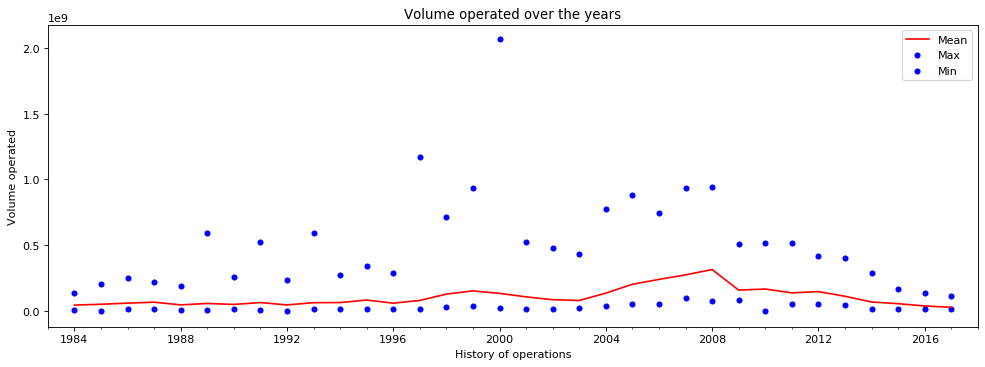

In [168]:
y = {'series' : ['Mean_Volume','Max_Volume','Min_Volume'],
     'names' : ['Mean','Max','Min'],
     'loc' : 'upper right',
     'kind' : ['line','scatter','scatter'],
     'ticker' : {'text':'Volume operated'},
     'color' : ['red','blue','blue']
     }

x = {'series' : ['Year'],
     'ticker' : {'text':'History of operations',
                 'locator':{
                       'major':4,
                       'minor':1
                    },
                  },
     'limits': [1983,2018]
    }
title='Volume operated over the years'

plot_volume_year_summary(volume_per_year_df,x,y,title)

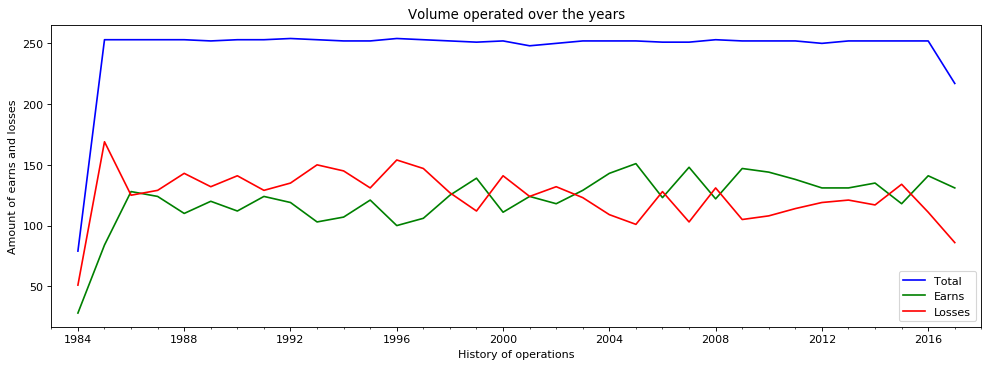

In [169]:
y = {'series' : ['Count','Count_Earns','Count_Losses'],
     'names' : ['Total','Earns','Losses'],
     'loc' : 'upper right',
     'kind' : ['line','line','line'],
     'ticker' : {'text':'Amount of earns and losses'},
     'color' : ['blue','green','red']
     }

x = {'series' : ['Year'],
     'ticker' : {'text':'History of operations',
                 'locator':{
                       'major':4,
                       'minor':1
                    },
                  },
     'limits': [1983,2018]
    }
title='Volume operated over the years'
plot_volume_year_summary(volume_per_year_df,x,y,title)

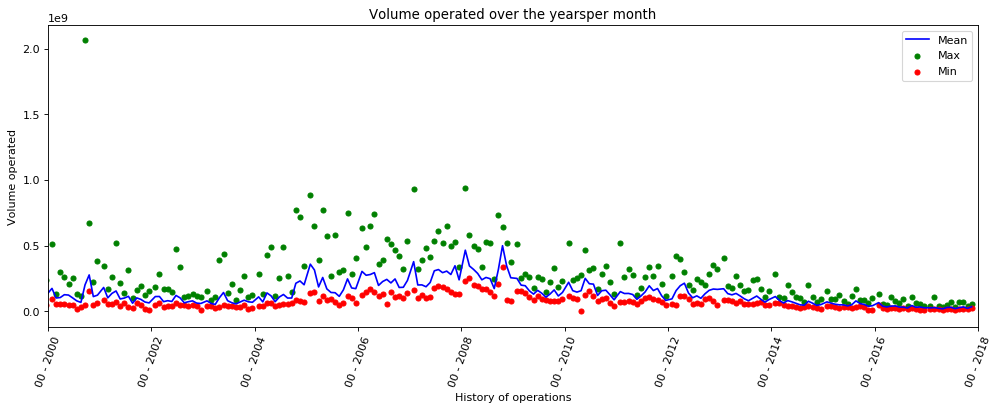

In [170]:
y = {'series' : ['Mean_Volume_Month','Max_Volume_Month','Min_Volume_Month'],
     'names' : ['Mean','Max','Min'],
     'loc' : 'upper right',
     'kind' : ['line','scatter','scatter'],
     'ticker' : {'text':'Volume operated'},
     'color' : ['blue','green','red']
     }

x = {'series' : ['index'],
     'ticker' : {'text':'History of operations',
                  'formatter': 'YYYYMMDD'
                  },
     'limits': [200000,201800]
    }
title='Volume operated over the yearsper month'
volume_per_year_per_month_df
plot_volume_year_summary(volume_per_year_per_month_df,x,y,title)

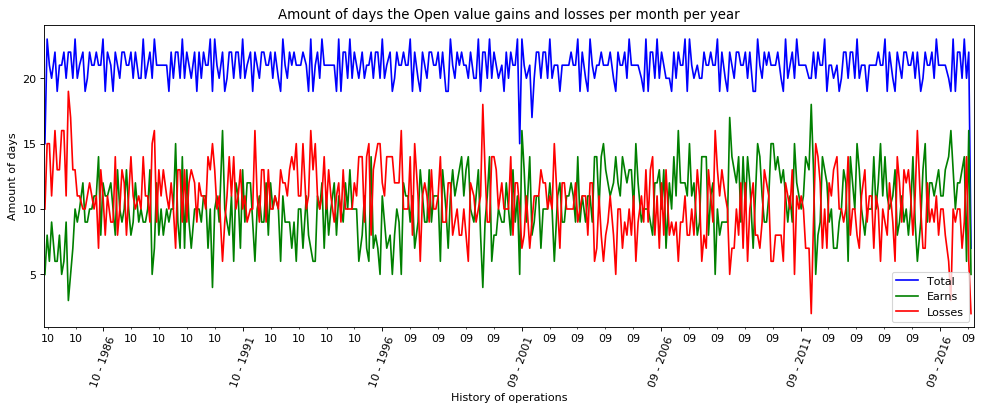

In [171]:
y = {'series' : ['Count_Month','Count_Earns_Month','Count_Losses_Month'],
     'names' : ['Total','Earns','Losses'],
     'loc' : 'upper right',
     'kind' : ['line','line','line'],
     'ticker' : {'text':'Amount of days'},
     'color' : ['blue','green','red']
     }

x = {'series' : ['index'],
     'ticker' : {'text':'History of operations',
                 'locator':{
                       'major':96*5.2,
                       'minor':96*1.04
                    },
                  'formatter': 'YYYYMM'
                  },
     'limits': [198470,201800],
    }
title='Amount of days the Open value gains and losses per month per year'
plot_volume_year_summary(volume_per_year_per_month_df,x,y,title)

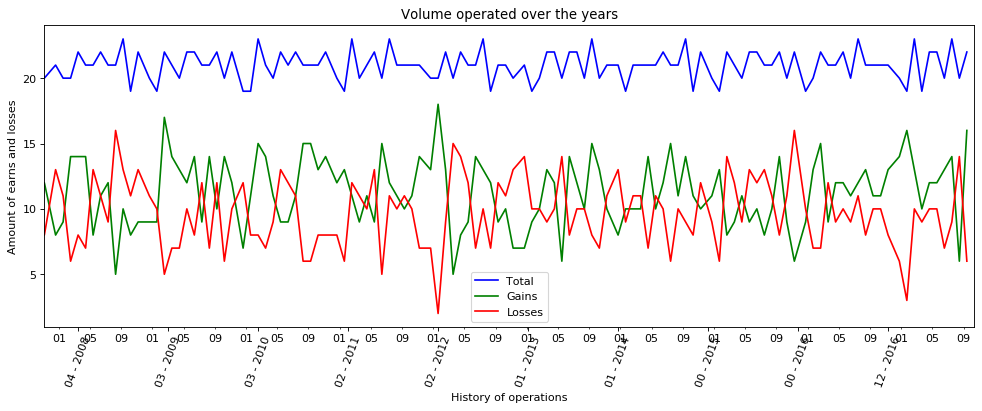

In [172]:
y = {'series' : ['Count_Month','Count_Earns_Month','Count_Losses_Month'],
     'names' : ['Total','Gains','Losses'],
     'loc' : 'upper right',
     'kind' : ['line','line','line'],
     'ticker' : {'text':'Amount of earns and losses'},
     'color' : ['blue','green','red']
     }

x = {'series' : ['index'],
     'ticker' : {'text':'History of operations',
                 'locator':{
                       'major':96,
                       'minor':8*4*1.04
                    },
                  'formatter': 'YYYYMM'
                  },
     'limits': [200796,201788]
    }
title='Volume operated over the years'
plot_volume_year_summary(volume_per_year_per_month_df[volume_per_year_per_month_df.index<201788],x,y,title)

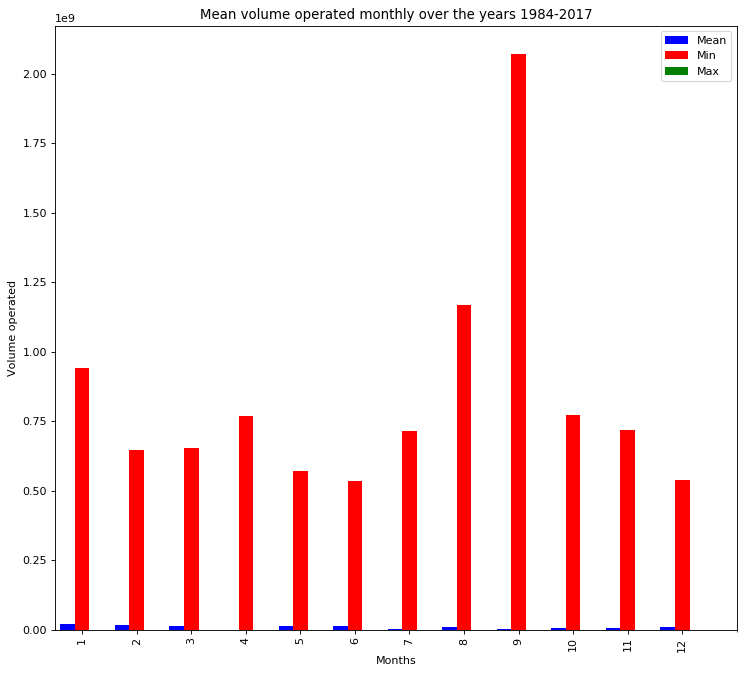

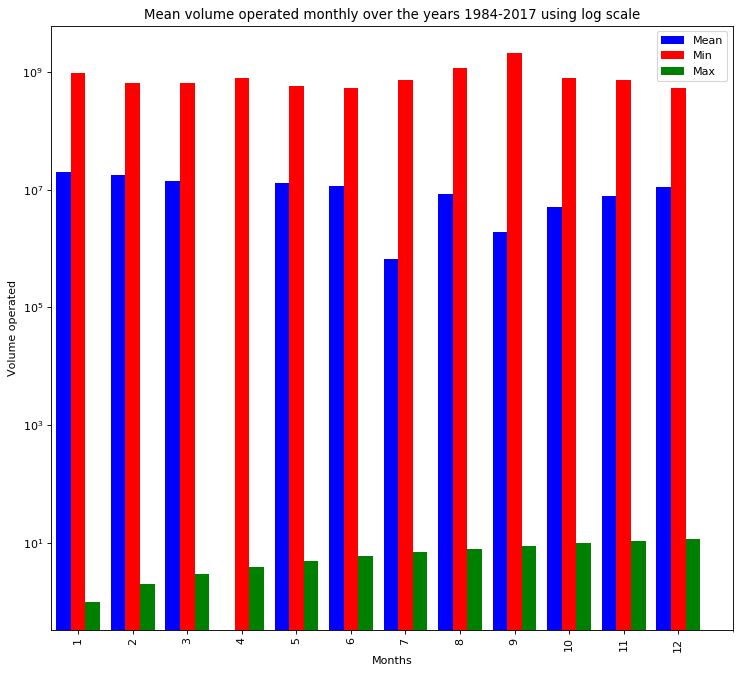

In [173]:
volume_month_df = df[['Volume','Month']].groupby('Month', as_index=False).agg(
    Max_Volume_Accum = ('Volume',max),
    Min_Volume_Accum = ('Volume',min),
    Mean_Volume_Accum = ('Volume','mean'),
    Sum_Volume_Accum = ('Volume',sum),
    
)

volume_month_df= (volume_month_df
                       .assign(Month = lambda x: x.index + 1))


fig = figure(num=None, figsize=(11, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
volume_month_df.plot(kind='bar',x='Month', y=['Mean_Volume_Accum','Min_Volume_Accum','Max_Volume_Accum'],color=['blue','red','green'], stacked=False , ax=ax, title='Mean volume operated monthly over the years 1984-2017', width=0.8, align='center')
ax.set_xlabel('Months')
ax.set_ylabel('Volume operated')
ax.set_xlim(-0.5,12)
ax.legend(['Mean', 'Min', 'Max'], loc='upper right')

fig = figure(num=None, figsize=(11, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
volume_month_df.plot(kind='bar',x='Month', y=['Mean_Volume_Accum','Min_Volume_Accum','Max_Volume_Accum'],color=['blue','red','green'], stacked=False , ax=ax, title='Mean volume operated monthly over the years 1984-2017 using log scale', width=0.8, align='center')
ax.set_xlabel('Months')
ax.set_ylabel('Volume operated')
plt.yscale('log')
ax.set_xlim(-0.5,12)
ax.legend(['Mean', 'Min', 'Max'], loc='upper right')


In [174]:
open_year_df = df[['Open','Diff_Today_Open','Diff_Tomorrow_Open','Month','Year']].groupby('Year').agg(
    Max_Open_Year = ('Open',max),
    Min_Open_Year = ('Open',min),
    Mean_Open_Year = ('Open','mean'),
    Min_Diff_Today_Year = ('Diff_Today_Open',min),
    Max_Diff_Today_Year = ('Diff_Today_Open',max),
    Mean_Diff_Today_Year = ('Diff_Today_Open','mean'),
)

open_year_df = (open_year_df
                  .assign(Year = lambda x: x.index)
                  .assign(index = lambda x: x.index - x.Year.min()+1))

open_year_df.set_index('index', inplace=True, drop=True)
open_year_df = pd.merge(open_year_df, df, on='Year')
to_merge_df = volume_per_year_per_month_df[['Max_Volume_Month', 'Min_Volume_Month', 'Mean_Volume_Month','Year', 'Month']]
open_year_df = pd.merge(open_year_df, to_merge_df, on=['Year','Month'])

write_data(open_year_df,'dataset_feature_vector_with_aggregations')

open_year_df


,Max_Open_Year,Min_Open_Year,Mean_Open_Year,Min_Diff_Today_Year,Max_Diff_Today_Year,Mean_Diff_Today_Year,Year,Yesterday_Date,Yesterday_Open,Yesterday_Close,...,Diff_Today_High,Diff_Today_Low,Month,Day,Yesterday_Month,Yesterday_Year,Yesterday_Day,Max_Volume_Month,Min_Volume_Month,Mean_Volume_Month
0,0.46487,0.36112,0.411776,-4.057308,5.934147,0.142377,1984,1984-09-07,0.42388,0.42388,...,-0.899725,-1.213163,9,10,9,1984,7,68847968.0,18022532.0,3.835188e+07
1,0.46487,0.36112,0.411776,-4.057308,5.934147,0.142377,1984,1984-09-10,0.42388,0.42134,...,2.709568,2.780061,9,11,9,1984,10,68847968.0,18022532.0,3.835188e+07
2,0.46487,0.36112,0.411776,-4.057308,5.934147,0.142377,1984,1984-09-11,0.42516,0.42902,...,-1.170193,-2.112146,9,12,9,1984,11,68847968.0,18022532.0,3.835188e+07
3,0.46487,0.36112,0.411776,-4.057308,5.934147,0.142377,1984,1984-09-12,0.42902,0.41618,...,2.073823,5.548080,9,13,9,1984,12,68847968.0,18022532.0,3.835188e+07
4,0.46487,0.36112,0.411776,-4.057308,5.934147,0.142377,1984,1984-09-13,0.43927,0.43927,...,3.489058,0.284563,9,14,9,1984,13,68847968.0,18022532.0,3.835188e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8357,174.48000,113.97000,145.864286,-6.089723,6.824785,0.199839,2017,2017-11-02,167.04000,167.51000,...,3.418702,3.533912,11,3,11,2017,2,59612161.0,24424877.0,3.546048e+07
8358,174.48000,113.97000,145.864286,-6.089723,6.824785,0.199839,2017,2017-11-03,173.38000,171.88000,...,0.414651,0.346021,11,6,11,2017,3,59612161.0,24424877.0,3.546048e+07
8359,174.48000,113.97000,145.864286,-6.089723,6.824785,0.199839,2017,2017-11-06,171.75000,173.63000,...,0.086029,1.279953,11,7,11,2017,6,59612161.0,24424877.0,3.546048e+07
8360,174.48000,113.97000,145.864286,-6.089723,6.824785,0.199839,2017,2017-11-07,173.29000,174.18000,...,0.630336,0.242368,11,8,11,2017,7,59612161.0,24424877.0,3.546048e+07


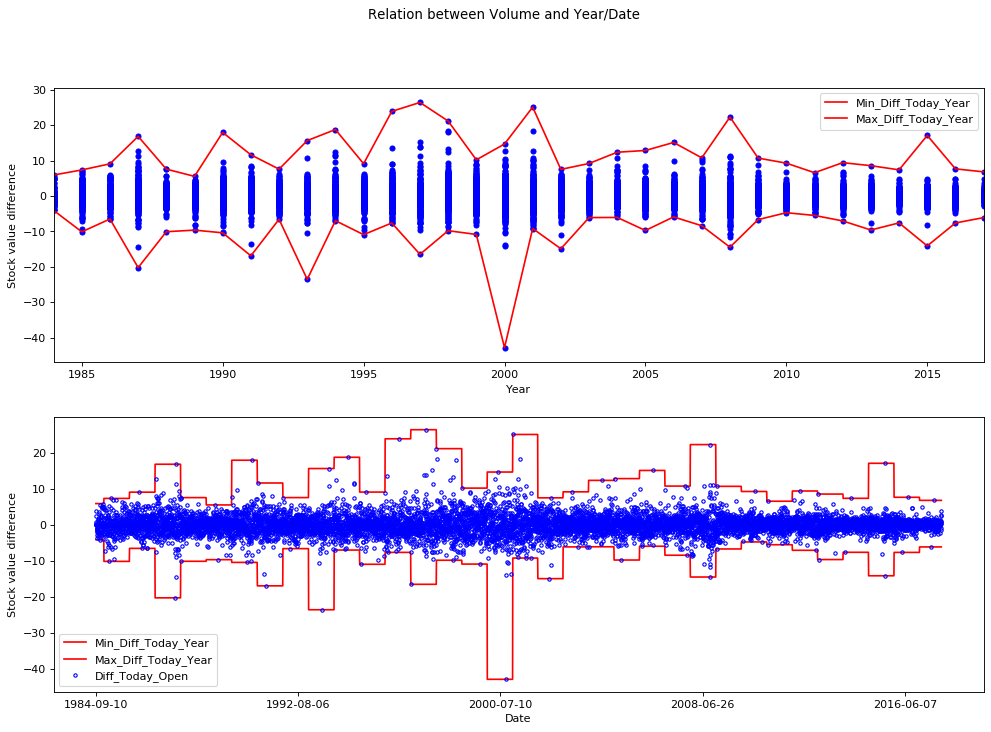

In [175]:
y = {'series' : ['Min_Diff_Today_Year','Max_Diff_Today_Year','Diff_Today_Open'],
       'ticker' : {'text':'Stock value difference',
                   'locator':{
                       'major':5,
                       'minor':1
                    }
                  }
     }
title = 'Relation between Volume and Year/Date'

plot_max_min_year_behavior(open_year_df,y,title)

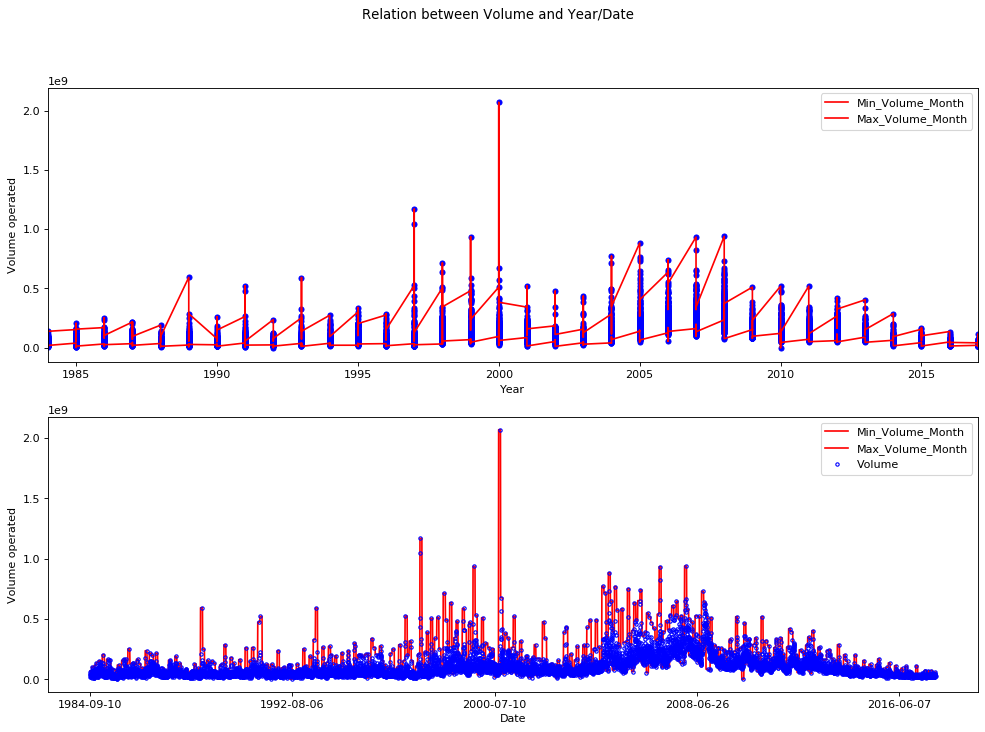

In [176]:
y = {'series' : ['Min_Volume_Month','Max_Volume_Month','Volume'],
       'ticker' : {'text':'Volume operated'}
     }
title = 'Relation between Volume and Year/Date'
plot_max_min_year_behavior(open_year_df,y,title)

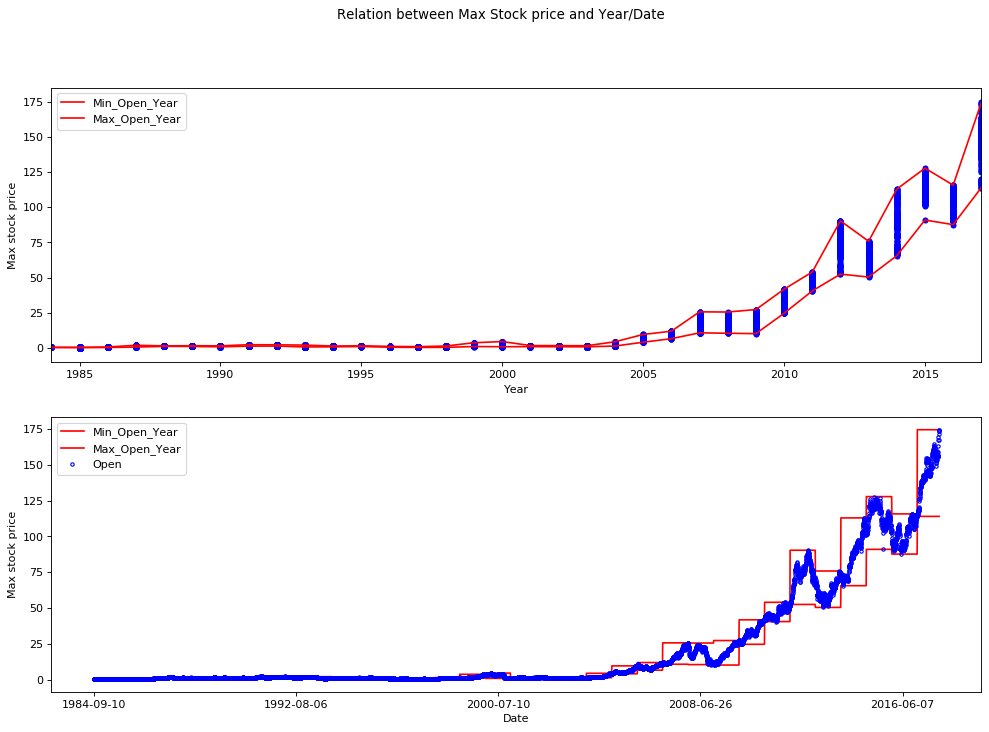

In [177]:
y = {'series' : ['Min_Open_Year','Max_Open_Year','Open'],
       'ticker' : {'text':'Max stock price'}
     }

title = 'Relation between Max Stock price and Year/Date'
plot_max_min_year_behavior(open_year_df,y,title)

# Building the data processing script

In [ ]:
get_processed_data_script_file = os.path.join(os.path.pardir,'src','data','get_processed_data.py')

In [ ]:
generate_feature_script_file = os.path.join(os.path.pardir,'src','features','feature_data.py')
print(generate_feature_script_file)
generate_utils_script_file = os.path.join(os.path.pardir,'src','data','dataset_utils.py')
print(generate_utils_script_file)
generate_visualizations_script_file = os.path.join(os.path.pardir,'src','visualization','visualizartions.py')
print(generate_utils_script_file)
generate_dataset_script_file = os.path.join(os.path.pardir,'src','data','processed_data.py')
print(generate_dataset_script_file)

In [ ]:
%%writefile $generate_utils_script_file
import os
import pandas as pd


def load_dataset(subfolder='', file='aapl.us.txt', data_type='raw', index_column=0):
    data_path = os.path.join(os.path.pardir, os.path.pardir, 'data', data_type, subfolder, file)
    print('Opening file ', data_path)
    df = pd.read_csv(data_path, index_col=index_column)
    print('%d missing values found' % df.isnull().sum().sum())
    return df


def write_dataset(dataset,filename_extension):
    processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
    dataset_path = os.path.join(processed_data_path, 'dataset_' + filename_extension + '.csv')
    dataset.to_csv(dataset_path)
    
    
    
#importing module 
import logging 
  
#Create and configure logger 
logging.basicConfig(filename="newfile.log", 
                    format='%(asctime)s %(message)s', 
                    filemode='w') 
  
#Creating an object 
logger=logging.getLogger() 
  
#Setting the threshold of logger to DEBUG 
logger.setLevel(logging.DEBUG) 
  
#Test messages 
logger.debug("Harmless debug Message") 
logger.info("Just an information") 
logger.warning("Its a Warning") 
logger.error("Did you try to divide by zero") 
logger.critical("Internet is down") 

In [ ]:
%%writefile $generate_feature_script_file
import pandas as pd
import numpy as np

def prepare_feture_vector(df):
    # Feature vector
    df_tomorrow = generate_tomorrow_dataset(df)
    df_yesterday = generate_yesterday_dataset(df)
    # concatenate yesterday - today and tomorrow
    df = pd.concat([df_yesterday, df, df_tomorrow], axis=1, sort=False)

    # eliminate nan values from before yesterday and after tomorrow
    df = df[1:-2]
    return (df
            .assign(Date=lambda x: pd.to_datetime(x.Date))
            .assign(Average_High_Low=lambda x: (x.High + x.Low) / 2)
            .assign(Average_Day=lambda x: (x.Open + x.Close) / 2)
            .assign(Diff_Close_Open=lambda x: (x.Close - x.Open) / x.Open)
            .assign(Diff_Tomorrow_Open=lambda x: (x.Tomorrow_Open - x.Open) / x.Open)
            .assign(Label=lambda x: np.where(((x.Tomorrow_Open - x.Open) > 0), 1, 0))
            .assign(Diff_Today_Open=lambda x: (x.Open - x.Yesterday_Open) / x.Yesterday_Open)
            .assign(Diff_Today_Close=lambda x: (x.Close - x.Yesterday_Close) / x.Yesterday_Close)
            .assign(Diff_Today_High=lambda x: (x.High - x.Yesterday_High) / x.Yesterday_High)
            .assign(Diff_Today_Low=lambda x: (x.Low - x.Yesterday_Low) / x.Yesterday_Low)
            .assign(Month = lambda x: x.Date.dt.month)
            .assign(Year = lambda x: x.Date.dt.year)
            .assign(Day = lambda x: x.Date.dt.day)
            .assign(Yesterday_Month = lambda x: x.Yesterday_Date.dt.month)
            .assign(Yesterday_Year = lambda x: x.Yesterday_Date.dt.year)
            .assign(Yesterday_Day = lambda x: x.Yesterday_Date.dt.day)
            )


def generate_tomorrow_dataset(today_dataset):
    df_tomorrow = today_dataset[['Date', 'Open']].copy()
    df_tomorrow = df_tomorrow[1:]
    df_tomorrow.columns = ['Tomorrow_Date', 'Tomorrow_Open']
    df_tomorrow['aux_index'] = df_tomorrow.index - 1
    df_tomorrow.set_index('aux_index', inplace=True, drop=True)

    return df_tomorrow


def generate_yesterday_dataset(today_dataset):
    df_yesterday = today_dataset[['Date', 'Open', 'Close', 'Volume', 'Low', 'High']].copy()
    df_yesterday.columns = ['Yesterday_Date', 'Yesterday_Open', 'Yesterday_Close', 'Yesterday_Volume', 
                            'Yesterday_Low',
                            'Yesterday_High']
    df_yesterday['aux_index'] = df_yesterday.index + 1
    df_yesterday.set_index('aux_index', inplace=True, drop=True)

    return df_yesterday

In [ ]:
%%writefile $generate_dataset_script_file
import pandas as pd
from src.data.dataset_utils import load_dataset, write_dataset
from src.features.feature_data import prepare_feture_vector


def process_dataset(product='Stocks', underlyer='aapl.us.txt'):
    dataset = load_dataset(product, underlyer, 'raw', index_column=False)
    dataset = prepare_feture_vector(dataset)
    write_dataset(dataset,'feature_vector')
    return dataset
    
    
def generate_train_dataset(dataset, split_date='2016-01-01'):
    dataset_aux = dataset[dataset.Date < split_date]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open', 'Label', 'Diff_Tomorrow_Open', 'Date', 'Yesterday_Date']) 
    return dataset_aux, result_df


def generate_train_dataset_lowerbound(dataset, split_date='2016-01-01', lower_bound = '2000-01-01'):
    dataset_aux = dataset[(dataset.Date < split_date) & (dataset.Date > lower_bound)]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index 
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label', 'Diff_Tomorrow_Open', 'Date', 'Yesterday_Date']) 
    return dataset_aux, result_df


def generate_test_dataset(dataset, split_date='2016-01-01'):
    dataset_aux = dataset[dataset.Date > split_date]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label', 'Diff_Tomorrow_Open', 'Date', 'Yesterday_Date']) 
    return dataset_aux, result_df


if __name__ == '__main__':
    dataset = process_dataset('Stocks', 'aapl.us.txt')

In [ ]:
# Compute the correlation matrix 
import seaborn as sns; sns.set()
corr_all = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()